In [1]:
import pandas as pd
import numpy as np
import os, sys

In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
DATA_PATH = '../data/ml-latest-small'

In [4]:
links_df = pd.read_csv(os.path.join(DATA_PATH, 'links.csv'))

In [5]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


### Web scraping

In [6]:
import requests
from bs4 import BeautifulSoup
from threading import Thread

In [7]:
%%timeit 
string = 'The quick brown fox jusmps over the lazy dog'
l_w = ['brown', 'jusmps']
for i in l_w:
    string = string.replace(i, ' ')

457 ns ± 5.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [170]:
string = 'The quick brown fox jusmps over the lazy dog'
l_w = ['brown', 'jusmps']
s1 = string.replace('brown', '').replace('jusmps', '')

In [7]:
import re

In [171]:
string = 'The quick brown fox jusmps over the lazy dog'
prohibitedWords = ['brown', 'jusmps']
big_regex = re.compile('|'.join(map(re.escape, prohibitedWords)))
s2 = big_regex.sub("", string)

In [9]:
prohibitedWords = ['\n', '  ']

In [10]:
class QuoteGetter(Thread):
    def __init__(self, id):
        super().__init__()
        self.id = id
        
    def run(self):
        base = 'https://www.imdb.com/title/tt0{}/'
        r = requests.get(base.format(self.id))
        soup = BeautifulSoup(r.content, "lxml")
        try:
            self.quote = (re
                          .compile('|'.join(map(re.escape, prohibitedWords)))
                          .sub("", soup
                               .find('div', {'class': "summary_text"})
                               .get_text())
                         )
        except:
            self.quote = ''

In [11]:
def get_quotes(ids):
    threads = [QuoteGetter(i) for i in ids]
    for thread in threads:
        thread.start()
    for thread in threads:
        thread.join()
    quotes = dict(zip(ids, [thread.quote for thread in threads]))
    return quotes

In [216]:
ids = list(links_df.imdbId[:1000])

In [217]:
description = get_quotes(ids)

In [584]:
def id2descripion(id):
    r = requests.get('https://www.imdb.com/title/tt0{}/'.format(id))
    page = BeautifulSoup(r.content, "html.parser")
    # short desscription
    ##text = page.find('div', {'class': "summary_text"}).text
    # StoryLine
    text = page.find('div', {'class': "inline canwrap"}).text
    return text

In [61]:
%%timeit
id = 113041
id2descripion(id)

664 ms ± 56.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [83]:
r = requests.get('https://www.imdb.com/title/tt0{}/'.format(id))
page = str(r.content)

In [81]:
page.find('div class="inline canwrap"')

#### Scrap image

In [11]:
from PIL import Image
from io import BytesIO

In [24]:
class QuoteImage(Thread):
    def __init__(self, id):
        super().__init__()
        self.id = id
        
    def run(self):
        base = 'https://www.imdb.com/title/tt0{}/'
        r = requests.get(base.format(self.id))
        soup = BeautifulSoup(r.content, "lxml")
        try:
            url = (soup
                          .find('div', 
                                attrs={'class': "poster"})
                          .find('img')['src'])
            response = requests.get(url)
            self.quote = Image.open(BytesIO(response.content))
        except:
            self.quote = ''

In [25]:
def get_Image(ids):
    threads = [QuoteImage(i) for i in ids]
    for thread in threads:
        thread.start()
    for thread in threads:
        thread.join()
    quotes = dict(zip(ids, [thread.quote for thread in threads]))
    return quotes

In [43]:
ids = list(links_df.imdbId[:1000])
img = get_Image(ids)

## Recommender collaborative filtering

In [20]:
movies_df = pd.read_csv(os.path.join(DATA_PATH, 'movies.csv'))

In [84]:
ratings_df = pd.read_csv(os.path.join(DATA_PATH, 'ratings.csv')).query("rating >= 4").drop(columns=['rating', 'timestamp'])

In [517]:
k_id = set((ratings_df.movieId.value_counts()[ratings_df.movieId.value_counts() > 1]).index)
ratings_df.query("movieId in @k_id", inplace=True)

In [518]:
id2id = {e: i for i, e in enumerate(ratings_df.movieId.unique())}
ratings_df['movieId'] = ratings_df.movieId.map(id2id)

In [519]:
list_movies = ratings_df.groupby('userId').agg(list).movieId

In [521]:
def to_onehot(labels, n_categories, dtype=torch.float32):
    batch_size = len(labels)
    one_hot_labels = torch.zeros(size=(batch_size, n_categories), dtype=dtype)
    for i, label in enumerate(labels):
        # Subtract 1 from each LongTensor because your
        # indexing starts at 1 and tensor indexing starts at 0
        label = torch.LongTensor(label)
        one_hot_labels[i] = one_hot_labels[i].scatter_(dim=0, index=label, value=1.)
    return one_hot_labels

In [522]:
n_user = ratings_df.userId.max() + 1
user_oh = to_onehot([[u] for u in ratings_df.userId], n_user, dtype=torch.float32)

In [523]:
n_movie = ratings_df.movieId.max() + 1
movie_oh = to_onehot([[m] for m in ratings_df.movieId], n_movie, dtype=torch.float32)

In [44]:
n_movie = ratings_df.movieId.max() + 1
output_oh = to_onehot([list_movies[u] for u in ratings_df.userId], n_movie, dtype=torch.float32)

In [524]:
class ratingsDataset(Dataset):
    
    def __init__(self, data, itemId, userId):
        
        self.itemId, self.userId = torch.LongTensor(data[itemId]), torch.LongTensor(data[userId])
        self.n_user, self.n_item = len(self.userId.unique()), len(self.itemId.unique())
        self.n = len(self.itemId)
        #self.itemInput, self.userInput = (to_onehot([[i] for i in self.itemId], self.itemId.max() + 1, dtype=torch.float32), 
        #                                  to_onehot([[u] for u in self.userId], self.userId.max() + 1, dtype=torch.float32))
        list_item = data.groupby(userId).agg(list)[itemId]
        self.output = to_onehot([list_item[u.item()] for u in self.userId], self.itemId.max() + 1, dtype=torch.float32)
        
    def __len__(self):
        return self.n
        
    def __getitem__(self, idx):
        return (self.itemId[idx], self.userId[idx], self.output[idx])

In [525]:
from torch.utils.data.dataset import random_split

In [528]:
split = 0.6

In [529]:
dataset = ratingsDataset(ratings_df, 'movieId', 'userId')
lengths = [int(dataset.__len__() * split), int(dataset.__len__() * (1-split)) + 1]
train_data, test_data = random_split(dataset, lengths)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

In [531]:
class reco(nn.Module):
    
    def __init__(self, nItem, nUser):
        super(reco, self).__init__()

        ## GMF
        self.embedding_user_gmf = torch.nn.Embedding(num_embeddings=nUser, embedding_dim=10)
        self.embedding_item_gmf = torch.nn.Embedding(num_embeddings=nItem, embedding_dim=10)      
        ## MLP
        self.embedding_user_mlp = torch.nn.Embedding(num_embeddings=nUser, embedding_dim=10)
        self.embedding_item_mlp = torch.nn.Embedding(num_embeddings=nItem, embedding_dim=10)
        self.nnItem = nn.Sequential(
            nn.Linear(10, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.nnUser = nn.Sequential(
            nn.Linear(10, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.nnFinal = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 10),
        )
        # total
        self.affine_output = nn.Linear(in_features=10+10, out_features=nItem)
        self.logistic = nn.Sigmoid()  
        
    def forward(self, item, user):
        # GMF
        user_embedding_gmf = self.embedding_user_gmf(user)
        item_embedding_gmf = self.embedding_item_gmf(item)        
        x_gmf = torch.mul(user_embedding_gmf, item_embedding_gmf)
        # MLP
        user_embedding_mlp = self.embedding_user_mlp(user)
        item_embedding_mlp = self.embedding_item_mlp(item)
        x1 = self.nnItem(item_embedding_mlp)
        x2 = self.nnUser(user_embedding_mlp)
        x_mlp = torch.cat((x1, x2), dim=1)
        x_mlp = self.nnFinal(x_mlp)
        # concat the two models
        vector = torch.cat((x_mlp, x_gmf), dim=1)
        logits = self.affine_output(vector)
        x = self.logistic(logits)   
        return x

In [532]:
R = reco(ratings_df.movieId.max() + 1, ratings_df.userId.max() + 1 )

In [533]:
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(R.parameters(), lr=0.001, betas=(0.5, 0.9))

In [534]:
all_losses = []

In [535]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [536]:
start = time.time()

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        items, users, targets = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = R(items, users)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        if i % 200 == 0:
            print('%s, %d %d %.4f' % (timeSince(start), e, i, loss))
        all_losses.append(loss.item())            

print('Finished Training')

0m 0s, 0 0.7172
0m 1s, 200 0.2000
0m 2s, 400 0.1954
0m 4s, 600 0.1315
0m 5s, 800 0.1483
0m 6s, 1000 0.1797
0m 8s, 1200 0.1355
0m 9s, 1400 0.1356
0m 11s, 1600 0.1629
0m 12s, 0 0.1189
0m 14s, 200 0.1729
0m 15s, 400 0.1519
0m 17s, 600 0.1674
0m 18s, 800 0.1705
0m 20s, 1000 0.1505
0m 21s, 1200 0.1522
0m 23s, 1400 0.1615
0m 24s, 1600 0.1046
0m 25s, 0 0.1401
0m 26s, 200 0.1437
0m 28s, 400 0.1387
0m 29s, 600 0.1373
0m 31s, 800 0.1280
0m 32s, 1000 0.1214
0m 34s, 1200 0.1220
0m 35s, 1400 0.1184
0m 37s, 1600 0.1176
0m 38s, 0 0.1070
0m 40s, 200 0.1110
0m 41s, 400 0.1227
0m 43s, 600 0.1014
0m 45s, 800 0.1225
0m 46s, 1000 0.1328
0m 48s, 1200 0.1171
0m 49s, 1400 0.1387
0m 51s, 1600 0.1169
0m 52s, 0 0.1158
0m 54s, 200 0.0824
0m 55s, 400 0.1004
0m 57s, 600 0.0892
0m 59s, 800 0.1209
1m 0s, 1000 0.1073
1m 2s, 1200 0.1096
1m 4s, 1400 0.0840
1m 5s, 1600 0.1086
Finished Training


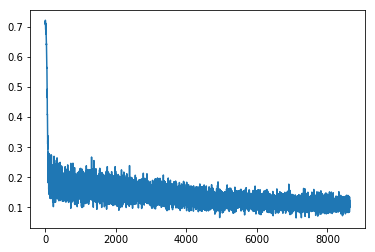

In [537]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [538]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        items, users, targets = data
        outputs = R(items, users)
        predicted = torch.round(outputs.data)
        keep_one = targets == 1
        total += 1
        correct += sum(predicted[keep_one] == targets[keep_one]).item() / targets[targets == 1].size(0)
        # total += targets.size(0)
        # correct += (predicted == targets).sum(dim=0).float()

print((correct / total))

0.04081026097339817


In [540]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        items, users, targets = data
        outputs = R(items, users)
        predicted = torch.round(outputs.data)
        total += targets.size(0)
        correct += (predicted == targets).sum(dim=0).float()

<BarContainer object of 3722 artists>

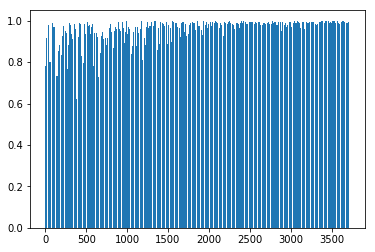

In [541]:
plt.bar(np.arange(ratings_df.movieId.max() + 1), (correct / total).numpy())

In [486]:
keep_one = targets == 1
predicted[keep_one] == targets[keep_one] 

tensor([1, 1, 0,  ..., 1, 1, 1], dtype=torch.uint8)

In [479]:
sum((predicted == targets)[0]) / 

tensor(211, dtype=torch.uint8)

In [515]:
torch.round(R(items, users))

tensor([[1., 0., 1.,  ..., 0., 0., 0.]], grad_fn=<RoundBackward>)

In [539]:
targ[targets == 1]

3722

## Recommender description based

In [218]:
imdbId2mId = {i + 1: m for i, m in enumerate(links_df.imdbId)}

In [219]:
import itertools

In [220]:
l = [c.split('|') for c in list(movies_df.genres)]

In [32]:
%timeit a = [item for sublist in l for item in sublist]
%timeit b = list(itertools.chain.from_iterable(l))

948 µs ± 11.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
646 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [221]:
import numpy as np
genres = list(np.unique(list(itertools.chain.from_iterable(l))))

In [222]:
genre_oh = np.array([[int(genres[i] in j) for i in range(20)] for j in movies_df.genres])

In [80]:
id = 4
description[imdbId2mId[id+1]], movies_df.title[id]

('George Banks must deal not only with the pregnancy of his daughter, but also with the unexpected pregnancy of his wife.',
 'Father of the Bride Part II (1995)')

In [114]:
## rule to keep only some movies
a = ratings_df.movieId.value_counts()
b = set(a[a.between(5, 50)].index)
c = ratings_df.query("movieId in @b")

In [223]:
r_df = pd.DataFrame({
    'title': [movies_df.title[i] for i in range(1000)],
    'description': [description[imdbId2mId[i+1]] for i in range(1000)]
})

In [235]:
contentMovie_df = pd.merge(r_df, pd.DataFrame(genre_oh[:100], columns=genres), right_index=True, left_index=True)

In [6]:
DATA_FOLDER = '../data'
FILE = 'train.csv'

In [237]:
contentMovie_df.drop(columns='title', inplace=True)
contentMovie_df.to_csv(os.path.join(DATA_FOLDER, FILE))

In [7]:
contentMovie_df = pd.read_csv(os.path.join(DATA_FOLDER, FILE))

In [113]:
desc = list(contentMovie_df.description)
desc = [d 
        if type(d) is not np.float 
        else 'Nothing' 
        for d in desc]

In [11]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [76]:
spacy_sw = spacy.lang.en.stop_words.STOP_WORDS
def fct(doc):
    return ' '.join([w.lemma_ for w in doc 
            if w.lemma_ not in spacy_sw and 
            not w.is_punct and 
            w.tag_ != 'VBN'
           ])

In [117]:
docs = nlp.pipe(desc)

In [118]:
clean_desc = [fct(doc) for doc in docs]

### Recommender image based

In [58]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms


class Img2Vec():

    def __init__(self, cuda=False, model='resnet-18', layer='default', layer_output_size=512):
        """ Img2Vec
        :param cuda: If set to True, will run forward pass on GPU
        :param model: String name of requested model
        :param layer: String or Int depending on model.  See more docs: https://github.com/christiansafka/img2vec.git
        :param layer_output_size: Int depicting the output size of the requested layer
        """
        self.device = torch.device("cuda" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model
        
        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Scale((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    def get_vec(self, img, tensor=False):
        """ Get vector embedding from PIL image
        :param img: PIL Image
        :param tensor: If True, get_vec will return a FloatTensor instead of Numpy array
        :returns: Numpy ndarray
        """
        image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

        if self.model_name == 'alexnet':
            my_embedding = torch.zeros(1, self.layer_output_size)
        else:
            my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

        def copy_data(m, i, o):
            my_embedding.copy_(o.data)

        h = self.extraction_layer.register_forward_hook(copy_data)
        h_x = self.model(image)
        h.remove()

        if tensor:
            return my_embedding
        else:
            if self.model_name == 'alexnet':
                return my_embedding.numpy()[0, :]
            else:
                return my_embedding.numpy()[0, :, 0, 0]

    def _get_model_and_layer(self, model_name, layer):
        """ Internal method for getting layer from model
        :param model_name: model name such as 'resnet-18'
        :param layer: layer as a string for resnet-18 or int for alexnet
        :returns: pytorch model, selected layer
        """
        if model_name == 'resnet-18':
            model = models.resnet18(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)

In [59]:
img2vec = Img2Vec()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\micka/.torch\models\resnet18-5c106cde.pth
46827520it [00:12, 3726367.60it/s]


In [143]:
with_img = [id for id in ids if type(img[id]) is not str]

In [83]:
%%time
matrix_img = torch.cat([img2vec.get_vec(img[id], tensor=True) for id in ids if id in with_img], dim=0)

Wall time: 1min 33s


In [136]:
array_img = matrix_img.view(741, 512).numpy()

In [139]:
from sklearn.metrics.pairwise import cosine_similarity

In [142]:
sim = cosine_similarity(array_img)

Choose one image 83


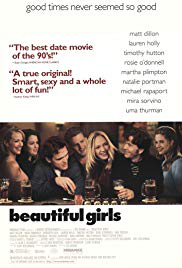

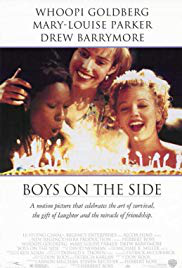

0.82190436


In [182]:
im = int(input('Choose one image'))
with_img[im]
display(img[with_img[im]])
display(img[with_img[np.argsort(-sim[im])[1]]])
print(-np.sort(-sim[im])[1])

In [183]:
import torch
import torchvision
import torchvision.transforms as transforms

In [184]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [193]:
for id in with_img:
    img[id].save('../data/image/'+str(id)+'.jpeg')

In [194]:
trainset = torchvision.datasets.ImageFolder('../data/image', transform=transform)

In [195]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)